In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
import itertools
from scipy.stats import norm
from scipy.spatial.distance import cdist, pdist, squareform

from bo_methods_lib.bo_functions_generic import LHS_Design

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 5.1 Gaussian Process Prior

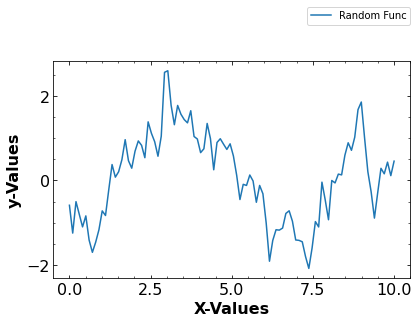

In [2]:
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 100
eps = 1e-7
# eps = 0

#Define X data
# Xexp = np.random.rand(nsamples)*10 
Xexp = np.linspace(0,10,nsamples).reshape(-1,ndim)
# Yexp = np.sin(Xexp)
# print(Xexp.shape)

#Create a function for euclidean distance between 2 x-vector values
def kernel(x1,x2):
    Vector_diff = x1-x2
    distance = np.exp(-np.linalg.norm(Vector_diff))
    return distance

#Define Covariance Matrix
cov = np.zeros((nsamples,nsamples))
#Loop over each sample
for i in range(nsamples):
    #Match with each sample
    for j in range(nsamples):
        x1 = Xexp[i]
        x2 = Xexp[j]
        cov[i,j] = kernel(x1,x2)

#Alternatively,
# def covkernel(xi,xj,l=1.0):
#     dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
#     return np.exp(-1*dij/l)

# cov = covkernel(Xexp,Xexp)

#Add jitter
cov += eps * np.eye(cov.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nsamples) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,cov)

#Plot data
plt.figure(figsize = (6.4,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
#         plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
#         plt.gca().axes.yaxis.set_ticklabels([])

#plot training data, testing data, and true values
plt.plot(Xexp, Y, label="Random Func")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
#         plt.legend(loc = "best")
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.1.1 Gaussian Process Posterior

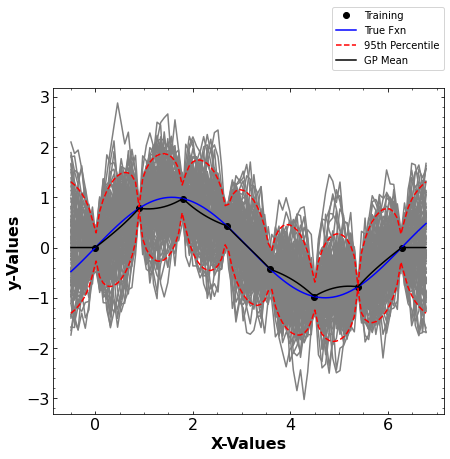

In [3]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 8
nsamples_test = 100
eps = 1e-14

#Define X data
# Xexp = np.random.rand(nsamples)*10 
X = np.linspace(0,2*np.pi,nsamples)[:,np.newaxis]
Y = np.sin(X)

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
XX = np.linspace(-0.5,2*np.pi+0.5,nsamples_test)[:,np.newaxis]
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@Y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup[:,0], sigmap, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.1.2 Higher Dimensions

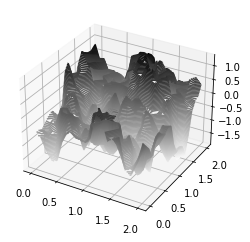

In [4]:
#In higher dimensions
#Set number of experimental data/ set rng
np.random.seed() #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim = 2
nx = 20
eps = 1e-14

#Define 2D X data
x = np.linspace(0,2,nx)
X = np.array(list(itertools.product(x, repeat=ndim)))

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nx**ndim) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,Sigma)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.contour3D(x, x, Y.reshape(nx,nx), 100, cmap='binary')

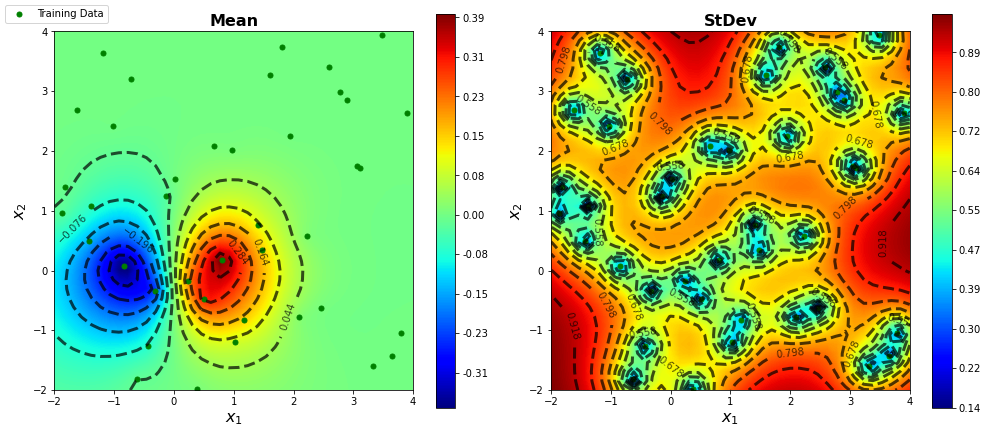

In [5]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 2
nsamples = 40
eps = 1e-14

#Generate X data from LHS
X = LHS_Design(nsamples, ndim, seed = 10)
#Modify X data to correct scale
X[:,0] = (X[:,0] - 0.5)*6 +1
X[:,1] = (X[:,1] - 0.5)*6 +1

#Generate y data
y = X[:,0]*np.exp(-X[:,0]**2 -X[:,1]**2)


xx = np.linspace(-2,4,nsamples)
XX_mesh = np.array(np.meshgrid(xx,xx))
XX = XX_mesh.reshape((2,nsamples**2)).T

#Create Covariance Matrix for X
#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Plot
X1, X2 = XX_mesh
Z1 = mup.reshape(nsamples,nsamples)
Z2 = sdp.reshape(nsamples,nsamples)
z = [Z1,Z2]
tot_lev = [60,60]
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = len(z), figsize = (14,6))
ax = axes
title = ["Mean", "StDev"]

for i in range(len(z)):      
    #Create a colormap and colorbar for each subplot
    cs_fig = ax[i].contourf(X1, X2,z[i], levels = 900, cmap = "jet")
    if np.amax(z[i]) < 1e-1 or np.amax(z[i]) > 1000:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format='%.2e')
    else:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format = '%2.2f')

    #Create a line contour for each colormap
    cs2_fig = ax[i].contour(cs_fig, levels=cs_fig.levels[::tot_lev[i]], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
    ax[i].clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev[i]][1::2], fontsize=10, inline=1)

    #plot training data X values
    ax[i].scatter(X[:,0],X[:,1], color="green",s=25, label = "Training Data", marker = "o")  

    #Get legend information
    if i == len(z)-1:
        handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
    ax[i].axis('scaled')  
    ax[i].set_xlabel('$x_1$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$x_2$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X1), right = np.amax(X1))
    ax[i].set_ylim(bottom = np.amin(X2), top = np.amax(X2))      

#Plots legend and title
plt.tight_layout()
fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

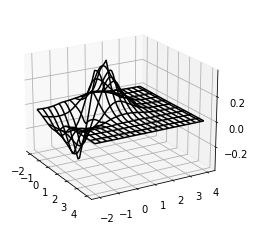

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.plot_wireframe(X1, X2, Z1.T, rstride=2, cstride=4, color = "black")
ax.view_init(20, -30)
plt.show()

# Section 5.2 GP Hyperparameters
## Section 5.2.1 Scale

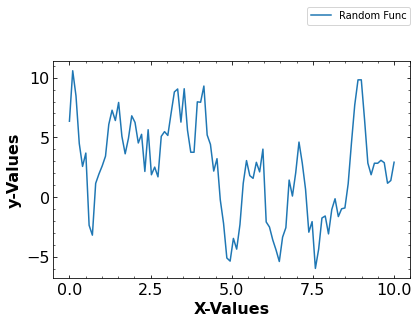

In [7]:
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1 #Number of dimensions
nsamples = 100 #Number of samples
eps = 1e-7 #Jitter factor
tau_2 = 25 #scale parameter
# eps = 0

#Define X data
Xexp = np.linspace(0,10,nsamples).reshape(-1,ndim)

#Define covariance matrix
Sigma = covkernel(Xexp,Xexp,l=1.0)

#Add jitter
cov += eps * np.eye(cov.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nsamples) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,cov*tau_2)

#Plot data
plt.figure(figsize = (6.4,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
#         plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
#         plt.gca().axes.yaxis.set_ticklabels([])

#plot training data, testing data, and true values
plt.plot(Xexp, Y.T, label="Random Func")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
#         plt.legend(loc = "best")
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

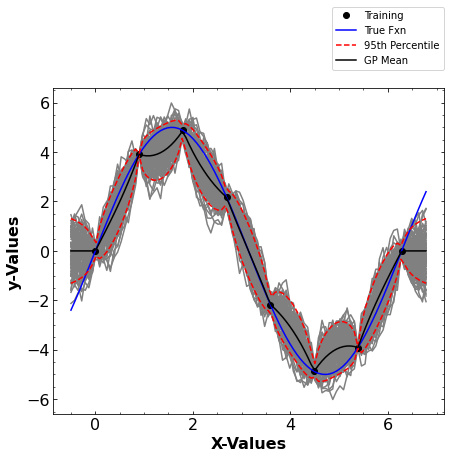

In [8]:
#Create a higher amplitude sine function example
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 8
eps = 1e-7

#Define X data
X = np.linspace(0,2*np.pi,nsamples).reshape(-1,ndim)
XX = np.linspace(-0.5,2*np.pi+0.5,100).reshape(-1,ndim)
Y = 5*np.sin(X)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
# Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@Y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup[:,0], sigmap, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

tau_2_hat:  8.628906602551314


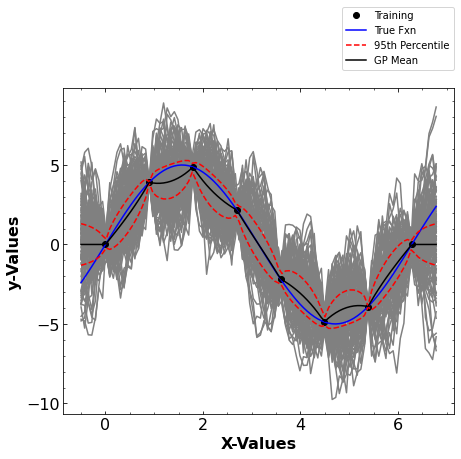

In [9]:
#Add scaling factor to approximation above and repeat
#Define covariance matricies which will be scaled by scaling factor tau
CX = SX
Ci = inv_Sig
CXX= SXX
tau_2_hat = Y.T@Ci@Y/len(Y)
tau_2_hat = tau_2_hat.squeeze()
print("tau_2_hat: ", tau_2_hat)

#Calculate posterior mean and variance
mup2 = CX@Ci@Y
sigmap2 = tau_2_hat*(CXX - CX@Ci@CX.T)
sdp2 = np.sqrt(np.diag(sigmap))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup2[:,0], sigmap2, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup2[:,0] + norm.ppf(0.05, loc=0, scale=sdp2)
q2 = mup2[:,0] + norm.ppf(0.95, loc=0, scale=sdp2)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup2[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [10]:
#Define function to calculate score
def score(Y, mu, Sigma, mah=False):
    Ymmu = Y - mu
    Sigmai = np.linalg.inv(Sigma)
    mahdist = Ymmu.T@Sigma@Ymmu
    if mah:
        return np.sqrt(mahdist)
    else:
        return -np.log(np.linalg.det(Sigma)) - mahdist   

In [11]:
#Define scores using scaling factor of 1 and optimized scaling factor
Ytrue = 5*np.sin(XX)
mah = True
scores = np.array([score(Ytrue, mup, sigmap, mah=mah), score(Ytrue, mup2, sigmap2, mah=mah)]).squeeze()
df = pd.DataFrame(np.array([scores]), columns = ["tau=1", "tau2_hat"])
print(df)

      tau=1   tau2_hat
0  10.37294  30.470512


## 5.2.2 Noise and Nuggets

In [12]:
#Define negative likelihood of nugget g as a function
def nlg(g, X, Y):
    n = len(Y)
    K = covkernel(X,X,l=1.0)
    K += g * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    ldetK = -np.log(np.linalg.det(K))
    ll = -(n/2)*np.log(Y.T@Ki@Y) - (1/2)*ldetK
    return -ll

In [13]:
#Optimize g
eps = 1e-7 #Jitter factor
Xnew = np.concatenate((X,X)) #Define 2 repeats of X (because we are adding noise)
n = Xnew.shape[0] #Define number of samples
Ynew = 5*np.sin(Xnew) + np.random.normal(size=(n,1)  ,loc = 0, scale = 1) #Define Y data
bnds = np.array([eps, np.var(Ynew)]).reshape(1,-1) #Set bounds on g between jitter and variance of Y
#optimize g
solution = scipy.optimize.minimize(nlg, 0.1, args = (Xnew,Ynew), method='L-BFGS-B', bounds=bnds, tol=1e-10 )
#Print solution: Note, as of 4/10/23 var(Y) = g
print(solution)
g = solution.x
g = g.flatten()
print(np.var(Ynew))
print(g)

      fun: -0.08833561696672376
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09847198])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([12.819943])
12.819943000789959
[12.819943]


In [14]:
#Define covariance matrix and optimize scaling factor tau2hat
K = covkernel(Xnew,Xnew,l=1.0)
K += g * np.eye(K.shape[0])
Ki = np.linalg.inv(K)
tau2hat = Ynew.T@Ki@Ynew/n
tau2hat = tau2hat.flatten()
print("tau: ", np.sqrt(tau2hat))
print("sigma: ", np.sqrt(tau2hat)*g)

tau:  [0.92236592]
sigma:  [11.82467849]


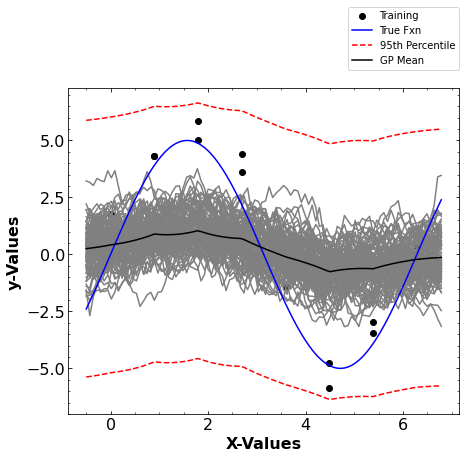

In [15]:
#Define Covariance matricies
KX = covkernel(XX,Xnew,l=1.0)
KXX = covkernel(XX,XX,l=1.0)
KXX += g * np.eye(KXX.shape[0])

#Calculate covariance matrix and GP mean
mup = KX@Ki@Ynew
sigmap = tau2hat*(KXX - KX@Ki@KX.T)
sdp = np.sqrt(np.diag(sigmap))

#Calculate 5th and 95th percentiles for calculations
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Define covariance matrix that uses eps instead of a nugget to add jitter
KXX2 = covkernel(XX,XX,l=1.0)
KXX2 += eps * np.eye(KXX.shape[0])
sigma_int = tau2hat*(KXX2 - KX@Ki@KX.T)

# #Generate 100 predictions, YY for XX using the eps based covariance predictions
YY = rng.multivariate_normal(mup[:,0], sigma_int, nsamples_test)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.scatter(Xnew[:,0], Ynew[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.2.3 Derivative-Based Hyperparameter Optimization

In [16]:
#Define the gradient of the negative likelihood w.r.t nugget g
def gnlg(g, X, Y):
    n = len(Y)
    K = covkernel(X,X,l=1.0)
    K += g * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    KiY = Ki@Y
    dll = (n/2)*KiY.T@KiY/(Y.T@KiY)-(1/2)*np.sum(np.diag(Ki))
    return -1*dll

In [17]:
#Optimize parameter g using the gradient
#Note. I'm not sure how to recreate what the example is doing in python. I don't think this is right
bnds = np.array([eps, np.var(Ynew)]).reshape(1,-1)
solution = scipy.optimize.minimize(nlg, 0.1, args = (Xnew,Ynew), method='L-BFGS-B', hess= gnlg, bounds=bnds, tol=1e-10 )
print(solution)
g = solution.x
g = g.flatten()
print("Value of nugget g: ", g)

      fun: -0.08833561696672376
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09847198])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([12.819943])
Value of nugget g:  [12.819943]


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:547: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
